In [62]:
from ultralytics import YOLO
import os
import pandas as pd
from PIL import Image
import bbox_visualizer as bbv
import numpy as np

In [2]:
df = pd.read_csv('test_labels.csv')
df.filename = df.filename.apply(lambda x: 'images/'+x)
df

,class,filename,ymax,xmax,ymin,xmin,width,height
0,Standard_poodle,images/n02113799_3978.jpg,427,429,50,69,500,443
1,Basset,images/n02088238_10183.jpg,364,375,67,0,500,375
2,Whippet,images/n02091134_17567.jpg,312,304,82,49,500,358
3,Kelpie,images/n02105412_6154.jpg,404,330,18,30,350,426
4,Keeshond,images/n02112350_7115.jpg,289,340,179,114,480,424
...,...,...,...,...,...,...,...,...
4111,Siberian_husky,images/n02110185_14597.jpg,383,233,6,21,375,500
4112,Bouvier_des_Flandres,images/n02106382_1925.jpg,173,154,0,0,174,174
4113,Japanese_spaniel,images/n02085782_2428.jpg,798,586,22,18,600,800
4114,Dandie_Dinmont,images/n02096437_926.jpg,288,453,102,20,500,375


In [53]:
path_to_weights = os.path.join(os.getcwd(),'best_36.pt')
model = YOLO(path_to_weights)

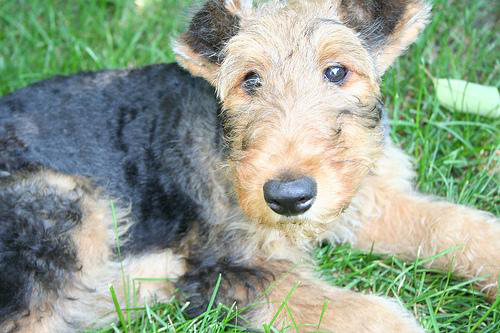

In [208]:
im = Image.open(df['filename'][10])
im

In [54]:
preds = model.predict(im)


0: 192x256 1 Border_terrier, 1 Irish_terrier, 166.6ms
Speed: 0.0ms preprocess, 166.6ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 256)


In [61]:
preds[0].boxes.xyxy

tensor([[  0.0000,   0.9255, 500.0000, 330.0455],
        [  0.0000,   0.0000, 500.0000, 331.0352]])

In [86]:
bboxs= dict(enumerate(preds[0].boxes))


{0: ultralytics.engine.results.Boxes object with attributes:
 
 cls: tensor([57.])
 conf: tensor([0.3296])
 data: tensor([[0.0000e+00, 9.2548e-01, 5.0000e+02, 3.3005e+02, 3.2958e-01, 5.7000e+01]])
 id: None
 is_track: False
 orig_shape: (333, 500)
 shape: torch.Size([1, 6])
 xywh: tensor([[250.0000, 165.4855, 500.0000, 329.1200]])
 xywhn: tensor([[0.5000, 0.4970, 1.0000, 0.9883]])
 xyxy: tensor([[  0.0000,   0.9255, 500.0000, 330.0455]])
 xyxyn: tensor([[0.0000, 0.0028, 1.0000, 0.9911]]),
 1: ultralytics.engine.results.Boxes object with attributes:
 
 cls: tensor([17.])
 conf: tensor([0.2768])
 data: tensor([[0.0000e+00, 0.0000e+00, 5.0000e+02, 3.3104e+02, 2.7677e-01, 1.7000e+01]])
 id: None
 is_track: False
 orig_shape: (333, 500)
 shape: torch.Size([1, 6])
 xywh: tensor([[250.0000, 165.5176, 500.0000, 331.0352]])
 xywhn: tensor([[0.5000, 0.4970, 1.0000, 0.9941]])
 xyxy: tensor([[  0.0000,   0.0000, 500.0000, 331.0352]])
 xyxyn: tensor([[0.0000, 0.0000, 1.0000, 0.9941]])}

In [91]:
bboxes = preds[0].boxes.xyxy
bbox1,bbox2 = bboxes
bbox1,bbox2 = bbox1.numpy(),bbox2.numpy()
np.min((bbox1[2],bbox2[2]))

500.0

In [130]:
def calculate_iou(bbox1,bbox2):
    bbox1,bbox2 = bbox1.xyxy.numpy()[0],bbox2.xyxy.numpy()[0]
    w=0
    h=0
    if (bbox1[0] <= bbox2[2]) and (bbox2[0] <= bbox1[2]):
        w = np.min((bbox1[2],bbox2[2])) - np.max((bbox1[0],bbox2[0]))
        if (bbox1[1] <= bbox2[3]) and (bbox2[1] <= bbox1[3]):
            h = np.min((bbox1[3],bbox2[3])) - np.max((bbox1[1],bbox2[1]))
    overlap = w*h
    area1 = (bbox1[2]-bbox1[0])*(bbox1[3]-bbox1[1])
    area2 = (bbox2[2]-bbox2[0])*(bbox2[3]-bbox2[1])
    iou = overlap/(area1+area2-overlap)
    return iou

In [74]:
calculate_iou(preds[0].boxes.xyxy)

164560.02


0.99421453

In [137]:
def delete_overlaps(boxes,threshold):
    bboxes = dict(enumerate(boxes))
    stop = False
    i = 0
    j = 1
    while not stop:
        bbox1 = bboxes[i]
        bbox2 = bboxes[j]
        iou = calculate_iou(bbox1,bbox2)
        # print(iou)
        if iou >= threshold:
            useless_box_id = np.argmin((bbox1.conf.numpy(),bbox2.conf.numpy()))
            bboxes.pop(useless_box_id)
            if useless_box_id == 0:
                i+= 1
            else:
                j+= 1
        else:
            j+= 1
        if j >= len(bboxes)-1:
            # print('limit j')
            i+= 1
            j = i+1
        if i >= len(bboxes)-2:
            # print('limit i')
            stop = True
        # print(stop)
        # print(i)
        # print(j)
    return list(bboxes.values())

потестить

In [138]:
boxes = preds[0].boxes
cleared_bboxes = delete_overlaps(boxes,0.8)
cleared_bboxes

[ultralytics.engine.results.Boxes object with attributes:
 
 cls: tensor([57.])
 conf: tensor([0.3296])
 data: tensor([[0.0000e+00, 9.2548e-01, 5.0000e+02, 3.3005e+02, 3.2958e-01, 5.7000e+01]])
 id: None
 is_track: False
 orig_shape: (333, 500)
 shape: torch.Size([1, 6])
 xywh: tensor([[250.0000, 165.4855, 500.0000, 329.1200]])
 xywhn: tensor([[0.5000, 0.4970, 1.0000, 0.9883]])
 xyxy: tensor([[  0.0000,   0.9255, 500.0000, 330.0455]])
 xyxyn: tensor([[0.0000, 0.0028, 1.0000, 0.9911]])]

In [142]:
cleared_bboxes[0].xyxy.numpy()

array([[          0,     0.92548,         500,      330.05]], dtype=float32)

In [215]:
def illustrate_boxes(preds,cl_map,threshold):
    img = preds.orig_img
    #better to use orig img
    boxes = delete_overlaps(preds.boxes,threshold)
    labels = []
    bboxes = []
    for i in range(len(boxes)):
        bbox = boxes[i].xyxy[0].numpy()
        bbox = list(map(int,bbox))
        bboxes.append(bbox)
        label = cl_map[int(boxes[i].cls[0].numpy())] + '    ' + str(np.round(boxes[i].conf[0].numpy(),2))
        labels.append(label)
    img1 = bbv.draw_multiple_rectangles(img,bboxes)
    img1 = bbv.add_multiple_labels(img1,labels,bboxes,top=False)
    return img1

In [147]:
def read_class_map(path):
    cl_map = pd.read_csv(path,index_col=0).to_dict()['label']
    return cl_map

In [ ]:
cl_map = read_class_map('class_mapping.csv')

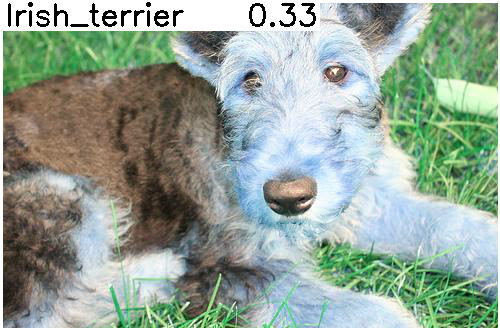

In [216]:
img = illustrate_boxes(preds[0],cl_map,0.8)
img = Image.fromarray(img)
img

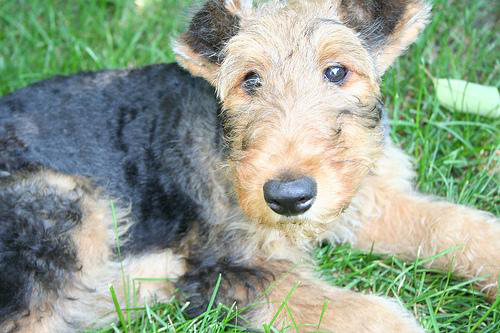

In [213]:
im

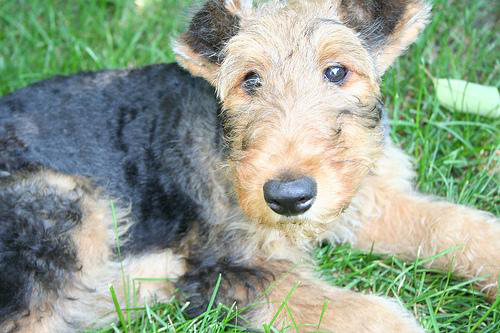

In [214]:
Image.fromarray(np.array(im))

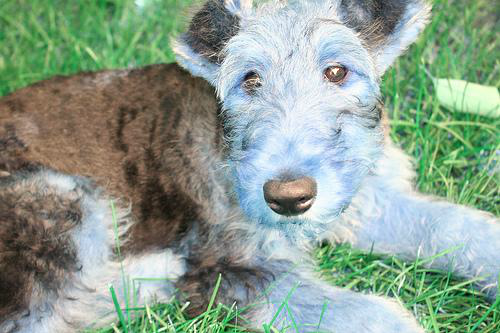

In [211]:
img = preds[0].orig_img
Image.fromarray(img)

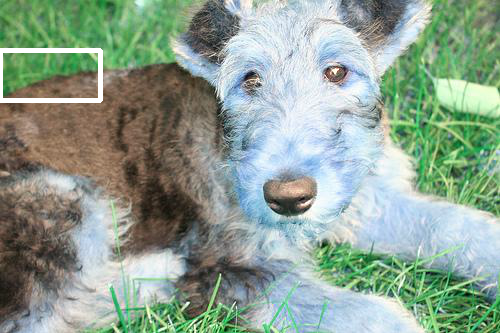

In [212]:
img1 = bbv.draw_multiple_rectangles(img,[[0,50,100,100]])
Image.fromarray(img1)

In [94]:
bbox = preds[0].boxes[0]
bbox.conf.numpy()

array([    0.32958], dtype=float32)

In [96]:
np.argmin((np.array(50),np.array(4)))

1

In [16]:
preds[0].boxes.conf

tensor([0.3296, 0.2768])

In [17]:
preds[0].boxes.cls

tensor([57., 17.])

In [10]:
preds[0]._keys

('boxes', 'masks', 'probs', 'keypoints', 'obb')

In [19]:
preds[0].orig_img.shape

(333, 500, 3)